In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
survey_all = pd.read_csv('./../../dbs/Swedish National Travel Survey (2011-2016)/survey_trips.csv')
survey_all.head()

,sub_id,home_county,home_municipality,home_district,workplace_municipality,workplace_district,commute_mode,commute_distance,workplace_county,commute_time,...,origin_county,desti_time,desti_county,distance,tt,mode,purpose,trip_weight,sub_weight,origin_t
0,20110111008,14.0,1480.0,b'SDN011',NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,2359.0,22.0,251.00,344.0,88.0,25.0,33268.862745,95.682583,2011-01-08 18:15
1,20110111013,1.0,180.0,NaN,180.0,NaN,10.0,7.1,1.0,20.0,...,1.0,850.0,1.0,NaN,20.0,10.0,2.0,338006.356351,972.119833,2011-01-10 8:30
2,20110111013,1.0,180.0,NaN,180.0,NaN,10.0,7.1,1.0,20.0,...,1.0,850.0,1.0,NaN,20.0,10.0,2.0,338006.356351,972.119833,2011-01-10 8:30
3,20110111013,1.0,180.0,NaN,180.0,NaN,10.0,7.1,1.0,20.0,...,1.0,850.0,1.0,NaN,20.0,10.0,2.0,338006.356351,972.119833,2011-01-10 8:30
4,20110111013,1.0,180.0,NaN,180.0,NaN,10.0,7.1,1.0,20.0,...,1.0,1230.0,1.0,0.52,20.0,1.0,2.0,338006.356351,972.119833,2011-01-10 11:30


# segments per trip

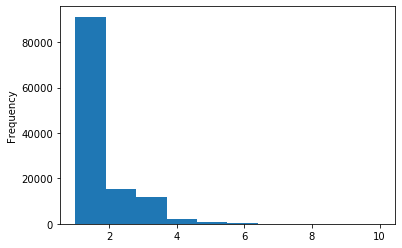

In [4]:
survey_all[['sub_id', 'trip_id', 'trip_main_id', 'trip_seg_id']].groupby(['sub_id', 'trip_id', 'trip_main_id']).size().plot.hist()

In [5]:
survey_all[['sub_id', 'trip_id', 'trip_main_id', 'trip_seg_id']][survey_all['trip_seg_id'] == 1].groupby(['sub_id', 'trip_id']).size().describe()

count    73379.000000
mean         1.654424
std          0.939566
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         26.000000
dtype: float64

/Users/kristofferek/miniconda3/envs/mscthesis/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kristofferek/miniconda3/envs/mscthesis/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


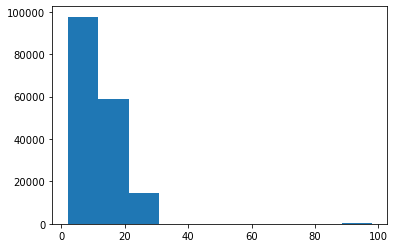

In [6]:
_ = plt.hist(survey_all['purpose'])

In [7]:
survey = survey_all[['sub_id', 'commute_mode', 'commute_distance', 'commute_time', 'date', 'trip_id', 'trip_main_id', 'origin_main_time', 'desti_main_time', 'origin_time', 'desti_time', 'distance', 'tt', 'mode', 'purpose', 'origin_t']]




In [8]:
trips = survey.groupby(['sub_id', 'trip_id', 'trip_main_id'], as_index=False).first()

In [9]:
trips['origin_main_time'].astype(str).unique()

array(['1815.0', '830.0', '1130.0', ..., '1259.0', '939.0', '608.0'],
      dtype=object)

In [10]:
def str_timestamp_to_datetime(time_column):
    def fn(row):
        d = pd.to_datetime(row['date'])
        timestr = str(int(row[time_column]))
        if len(timestr) > 2:
            hour, minute = timestr[:-2], timestr[-2:]
            d = d.replace(hour=int(hour), minute=int(minute))
            return d
        else:
            d = d.replace(hour=0, minute=int(timestr))
            return d
        print(timestr)
    return fn

def trips_clean(df):
    # purpose
    df = df.dropna(subset=['purpose'])
    df = df.assign(purpose=df['purpose'].astype(int))
    pmap = pd.read_excel("./../../dbs/Swedish National Travel Survey (2011-2016)/variable_values.xlsx", sheet_name="purpose")
    pmap = pmap.rename(columns={'value': 'purpose'})
    df = df.merge(pmap, on='purpose').rename(columns={ 'meaning': 'purpose_meaning'})
    # timestamps
    df = df.dropna(subset=['desti_main_time', 'origin_main_time'])
    df = df.assign(origin_time=df[['date', 'origin_main_time']].apply(str_timestamp_to_datetime('origin_main_time'), axis=1))
    df = df.assign(destination_time=df[['date', 'desti_main_time']].apply(str_timestamp_to_datetime('desti_main_time'), axis=1))
    return df

In [11]:
ts = trips_clean(trips)
ts

,sub_id,trip_id,trip_main_id,commute_mode,commute_distance,commute_time,date,origin_main_time,desti_main_time,origin_time,desti_time,distance,tt,mode,purpose,origin_t,purpose_meaning,destination_time
0,20110111008,1.0,1.0,NaN,NaN,NaN,2011-01-08,1815.0,2359.0,2011-01-08 18:15:00,2359.0,251.0,344.0,88.0,25,2011-01-08 18:15,Other,2011-01-08 23:59:00
1,20110111016,1.0,1.0,10.0,NaN,30.0,2011-01-07,940.0,1000.0,2011-01-07 09:40:00,1340.0,6.0,75.0,1.0,25,2011-01-07 9:40,Other,2011-01-07 10:00:00
2,20110111016,1.0,2.0,10.0,NaN,30.0,2011-01-07,1230.0,1310.0,2011-01-07 12:30:00,1340.0,6.0,75.0,1.0,25,2011-01-07 12:30,Other,2011-01-07 13:10:00
3,20110111016,1.0,3.0,10.0,NaN,30.0,2011-01-07,1325.0,1340.0,2011-01-07 13:25:00,1340.0,6.0,75.0,1.0,25,2011-01-07 13:25,Other,2011-01-07 13:40:00
4,20110111036,1.0,1.0,50.0,3.0,10.0,2011-01-09,730.0,745.0,2011-01-09 07:30:00,745.0,3.2,15.0,501.0,25,2011-01-09 7:30,Other,2011-01-09 07:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121300,20151561016,1.0,2.0,NaN,NaN,NaN,2015-04-16,1145.0,1150.0,2015-04-16 11:45:00,1250.0,52.0,45.0,501.0,10,2015-04-16 11:45,Booking tickets,2015-04-16 11:50:00
121301,20151561016,1.0,3.0,NaN,NaN,NaN,2015-04-16,1230.0,1250.0,2015-04-16 12:30:00,1250.0,52.0,45.0,501.0,10,2015-04-16 12:30,Booking tickets,2015-04-16 12:50:00
121302,20160141028,1.0,1.0,NaN,NaN,NaN,2016-01-08,1155.0,1200.0,2016-01-08 11:55:00,1315.0,18.0,25.0,501.0,10,2016-01-08 11:55,Booking tickets,2016-01-08 12:00:00
121303,20160141028,1.0,2.0,NaN,NaN,NaN,2016-01-08,1210.0,1225.0,2016-01-08 12:10:00,1315.0,18.0,25.0,501.0,10,2016-01-08 12:10,Booking tickets,2016-01-08 12:25:00


In [29]:
print(ts['purpose_meaning'].unique())
print(ts['purpose'].unique())

['Other' 'Commuting' 'Other leisure activities' 'Other vacation trip'
 'Shopping' 'Exercise and outdoor activities' 'Healthcare'
 'Pick up another person' 'School' 'Family and friends'
 'Restaurant and cafe' 'Pick/drop things' 'Business' 'Entertainment'
 'Postal or bank cases' 'Hobbies, music practice, study circles, courses'
 "Participate in or participate in children's leisure activities"
 'Child custody' 'Other service' 'Association life, religious practice'
 'Funeral' 'Study' 'Booking tickets']
[25  2 22 21  7  6 17  8 13  3 14 16 23  4 18  9 15 20 11 12 19 24  5 10]


In [13]:
ts_p = ts[['purpose_meaning', 'origin_time']].set_index('purpose_meaning')
ts_p['hourofday'] = ts_p['origin_time'].dt.hour 
ts_p['weekday'] = ts_p['origin_time'].dt.weekday
ts_p

,origin_time,hourofday,weekday
purpose_meaning,,,
Other,2011-01-08 18:15:00,18,5
Other,2011-01-07 09:40:00,9,4
Other,2011-01-07 12:30:00,12,4
Other,2011-01-07 13:25:00,13,4
Other,2011-01-09 07:30:00,7,6
...,...,...,...
Booking tickets,2015-04-16 11:45:00,11,3
Booking tickets,2015-04-16 12:30:00,12,3
Booking tickets,2016-01-08 11:55:00,11,4


In [14]:
print(ts_p.shape)
ts_p_weekday = ts_p[ts_p['weekday'] < 5].copy(deep=True)
print('Weekday trips: ' + str(len(ts_p_weekday)))
ts_p_weekend = ts_p[ts_p['weekday'] >= 5].copy(deep=True)
print('Weekend trips: ' + str(len(ts_p_weekend)))

(118695, 3)
Weekday trips: 88735
Weekend trips: 29960


In [15]:
time_purpose_weekday = ts_p_weekday.reset_index().groupby(['hourofday', 'purpose_meaning']).size().unstack().fillna(0)
time_purpose_weekend = ts_p_weekend.reset_index().groupby(['hourofday', 'purpose_meaning']).size().unstack().fillna(0)
time_purpose_weekday = time_purpose_weekday.drop('Booking tickets', axis=1)
#time_purpose_weekday = time_purpose_weekday / 5
#time_purpose_weekend = time_purpose_weekend / 2
#for n, d in time_purpose_weekday.iteritems():
#    time_purpose_weekday[n] = time_purpose_weekday[n] / ts_p.groupby('purpose_meaning').size()[n]
#    time_purpose_weekend[n] = time_purpose_weekend[n] / ts_p.groupby('purpose_meaning').size()[n]

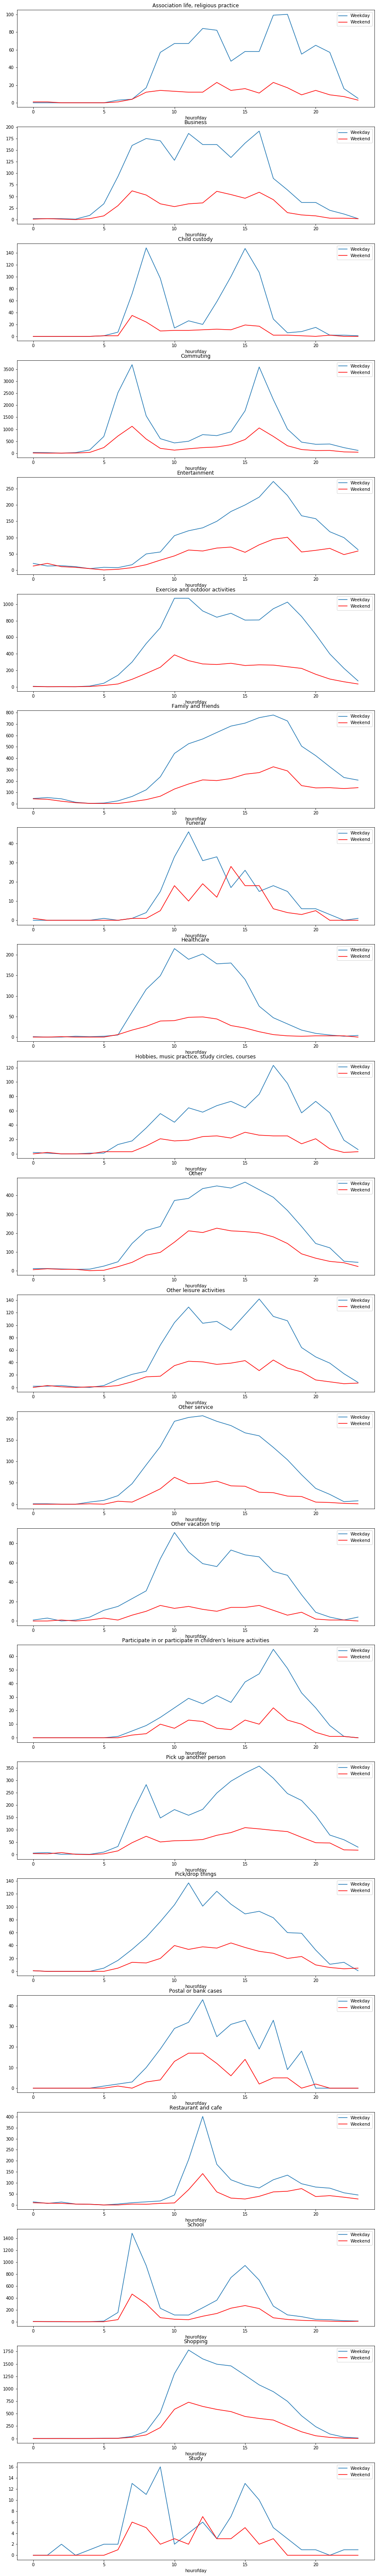

In [16]:
fig, axes = plt.subplots(nrows=len(time_purpose_weekday.columns), ncols=1, figsize=(15,len(time_purpose_weekday.columns)*5))
i = 0
for c in time_purpose_weekday.columns:
    time_purpose_weekday[c].plot(ax=axes[i], label='Weekday')
    time_purpose_weekend[c].plot(ax=axes[i], color='red', label='Weekend')
    axes[i].set_title(c)
    axes[i].legend()
    i += 1

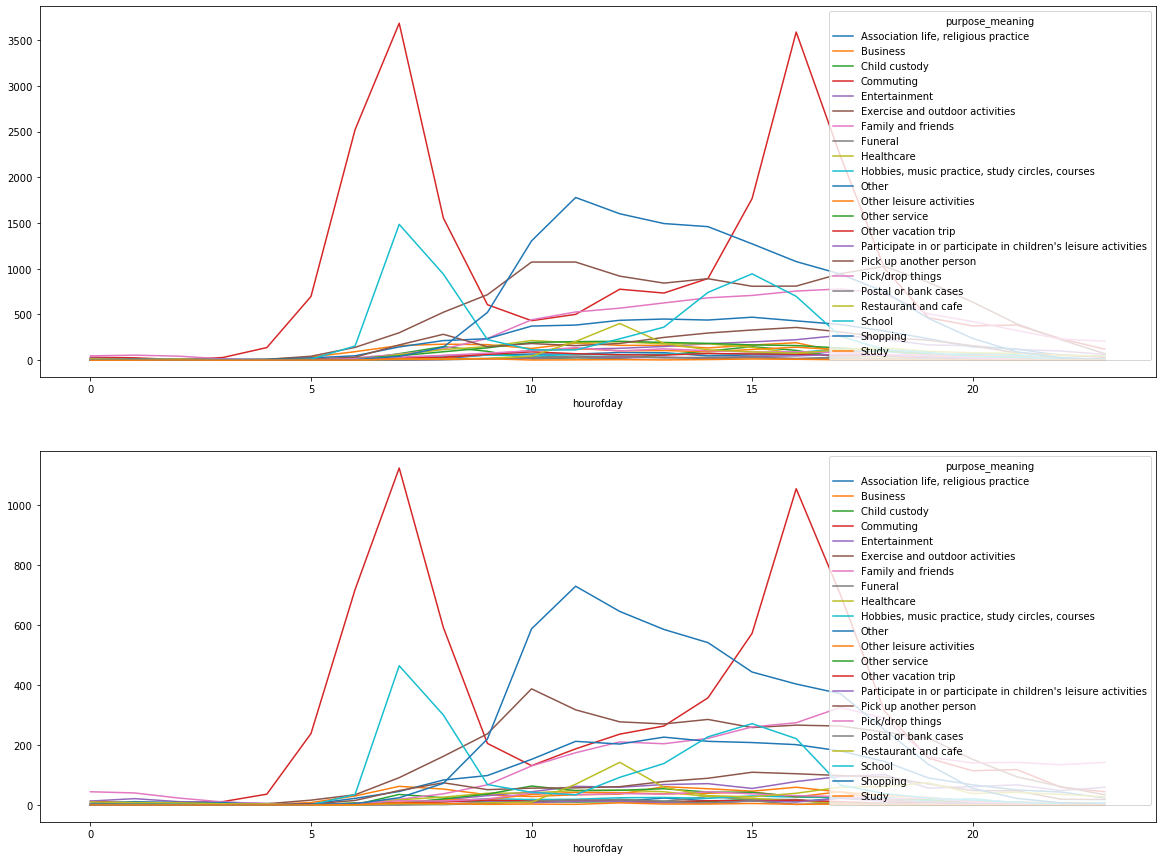

In [28]:
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
time_purpose_weekday.plot(ax=axes[0], label='Weekday')
time_purpose_weekend.plot(ax=axes[1], label='Weekend')